In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np, pandas as pd
import pickle

def gaus(x, normalization,location, stdev):
    u = (x - location)/stdev
    return normalization* np.exp(-0.5*u**2)

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)


In [2]:
testpoints=np.array([255,232,203,174,139,97,77,46,21])
locations = testpoints - 14
dataframes = [-666]*len(locations)
positions = ["Right End","Far Right", "Center Right", "Right", "Center", "Left","Center Left", "Far Left", "Left End"]
colors=["blue","green","red"]

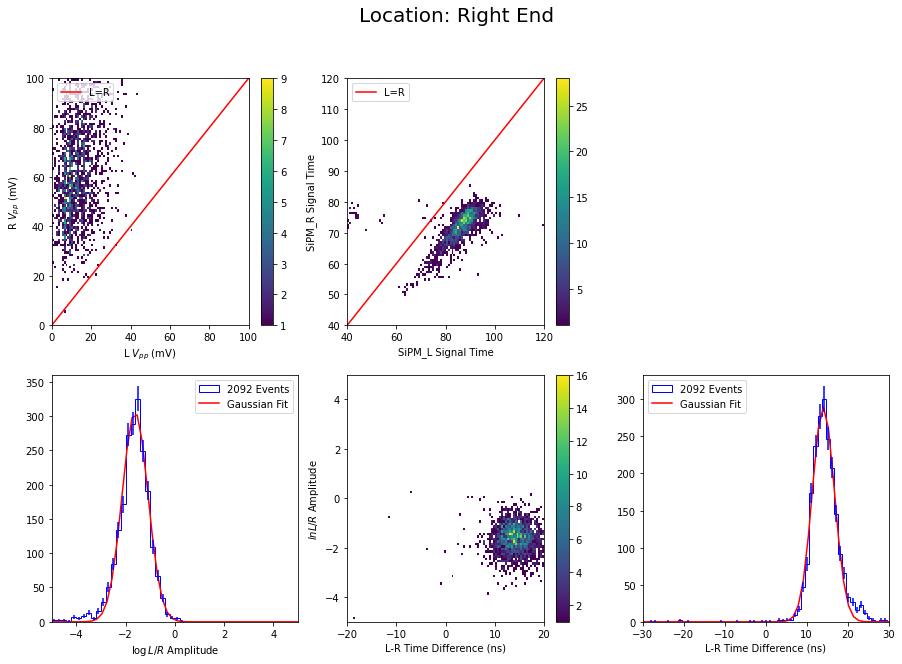

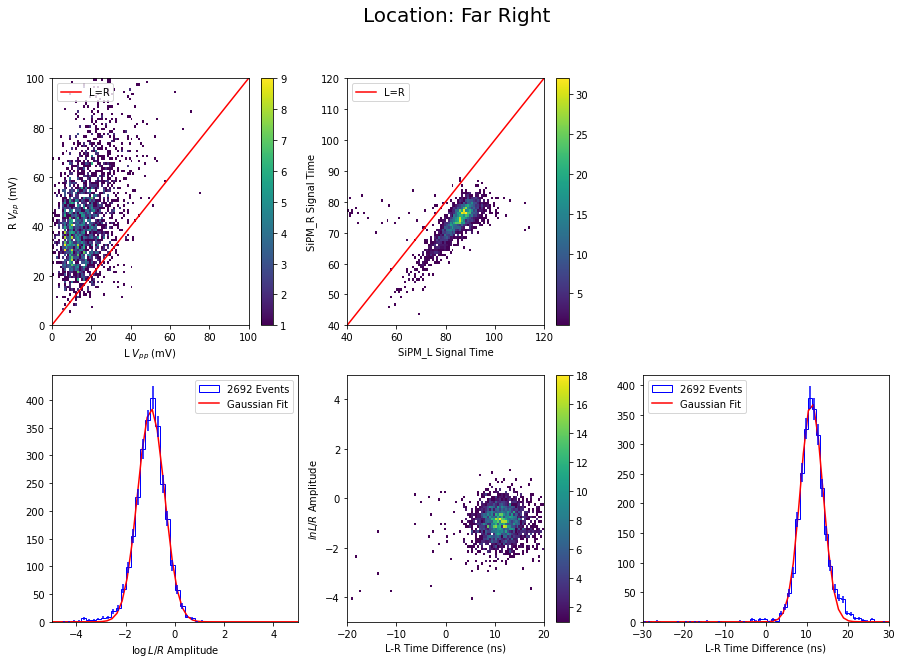

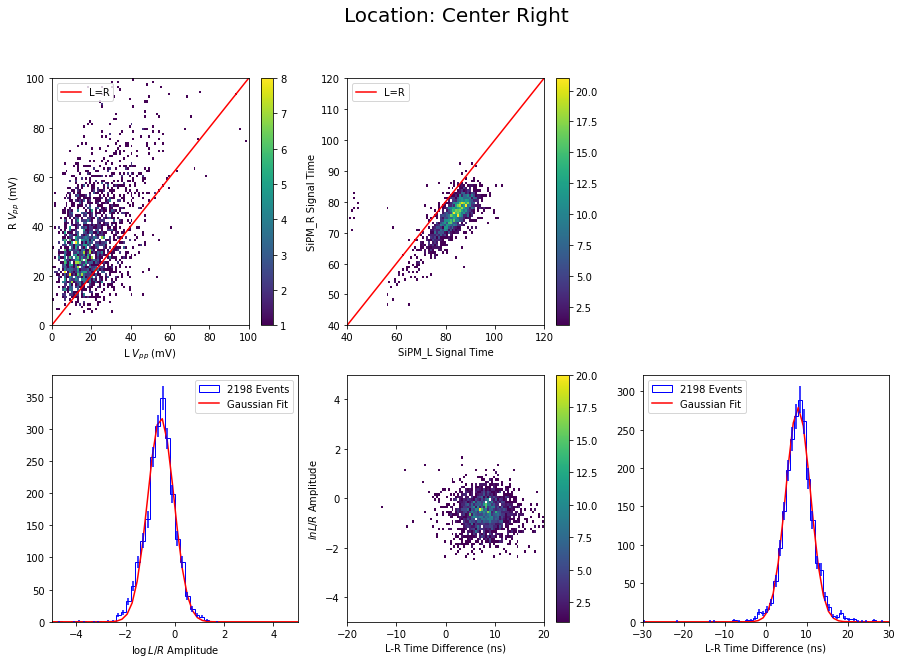

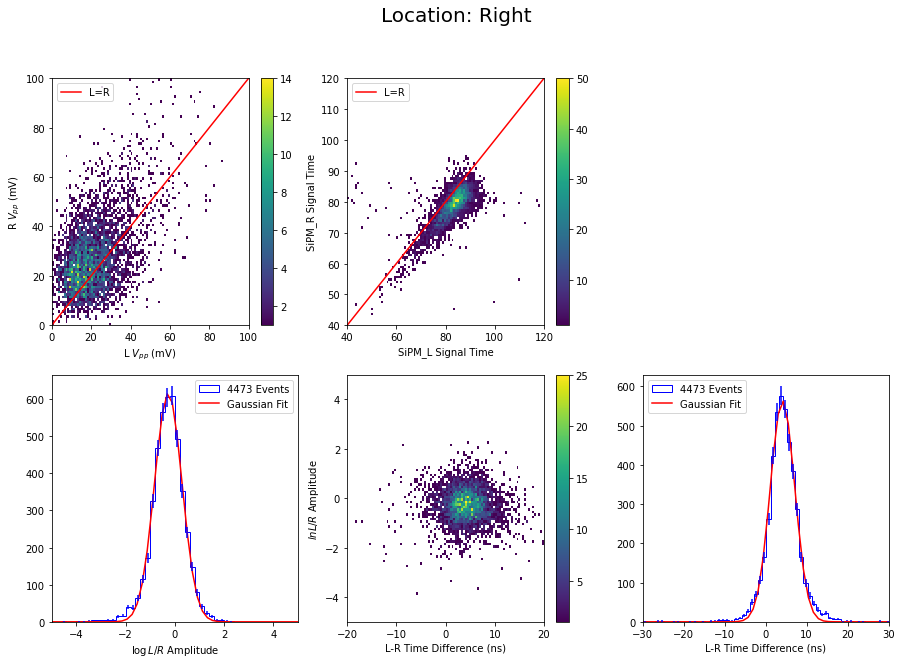

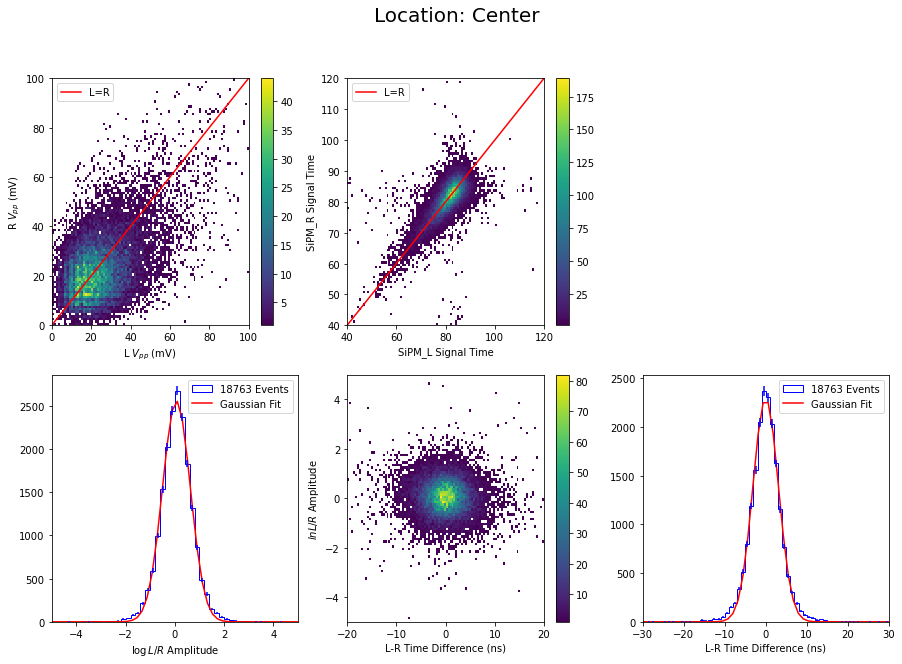

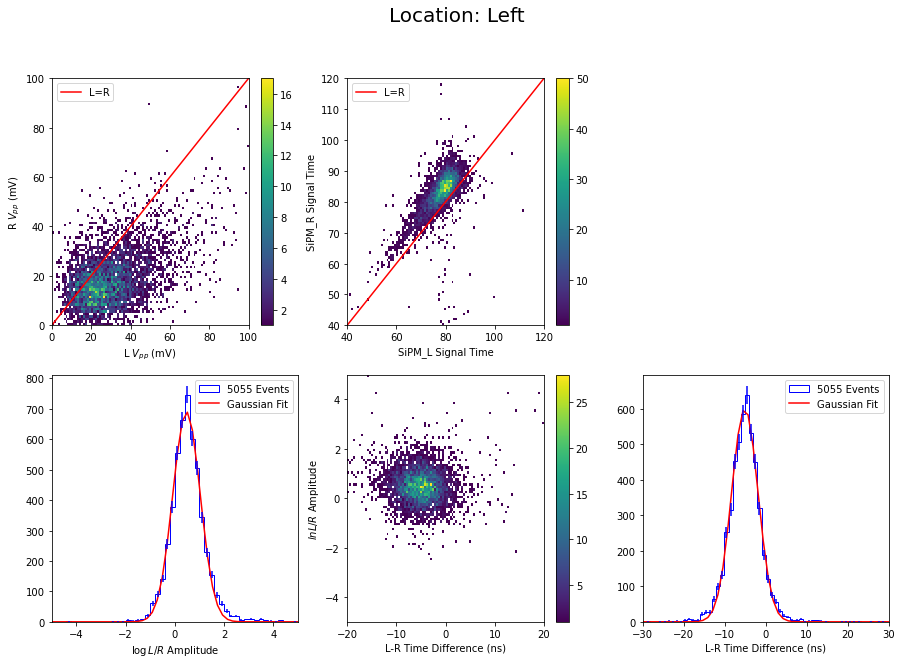

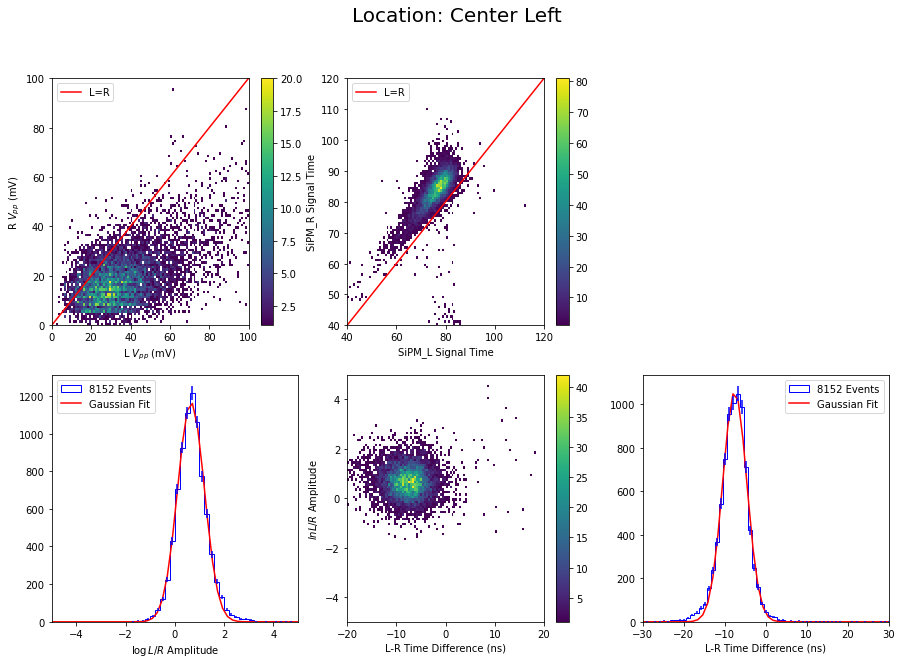

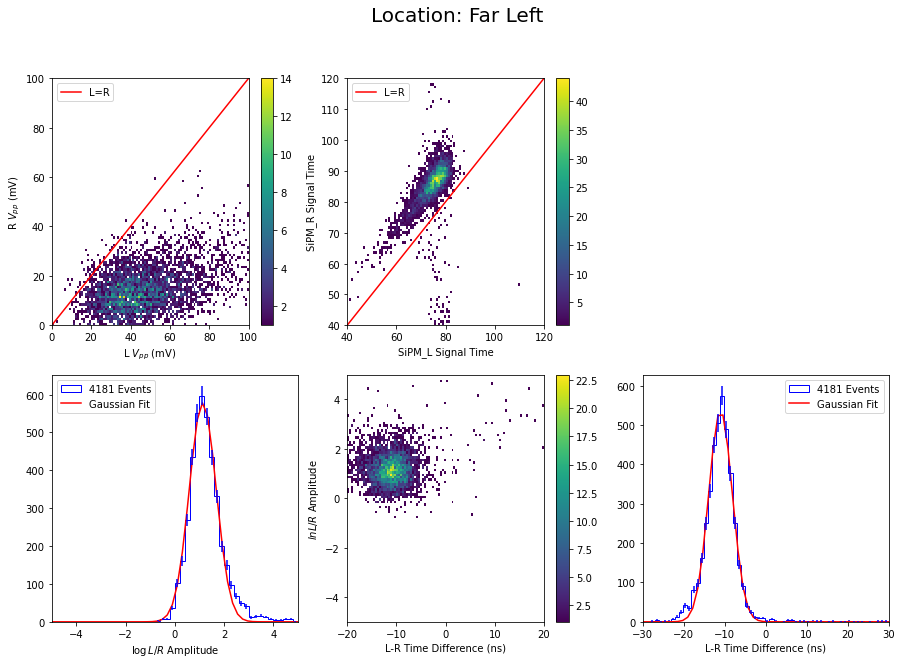

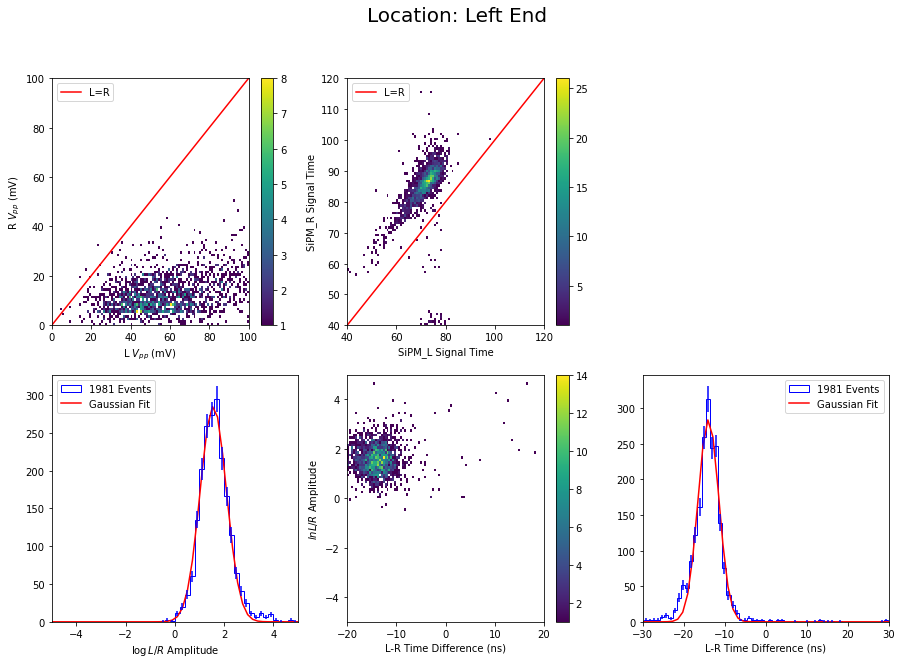

In [3]:
for i in range(len(locations)):
    with open(f'raw_data/longbar_take2/Pos_{testpoints[i]}_5mV.pkl', 'rb') as f:
        df = pickle.load(f)
    dataframes[i] = df.query("ch4_time_fit >= 0 & ch3_time_fit >= 0 & ch4_P2P_fit > 0 & ch3_P2P_fit > 0")
    fig,ax = plt.subplots(2,3,figsize=(15,10))
    fig.suptitle(f"Location: {positions[i]}", fontsize=20)
    binresolution = 1
    bincount = int(np.floor( (max(dataframes[i].ch4_time_fit-dataframes[i].ch3_time_fit)-min(dataframes[i].ch4_time_fit-dataframes[i].ch3_time_fit))/binresolution ))

    ax[0][0].set_xlabel("L $V_{pp}$ (mV)")
    ax[0][0].set_ylabel("R $V_{pp}$ (mV)")
    AmpImage = ax[0][0].hist2d(dataframes[i].ch3_P2P_fit,dataframes[i].ch4_P2P_fit,bins=(100,100),cmin=1,label=f"{len(dataframes[i].ch4_time_fit)} Events",range=[[0, 100], [0, 100]])
    ax[0][0].plot(np.linspace(0,100,2),np.linspace(0,100,2),color='r',label="L=R")
    fig.colorbar(AmpImage[-1],ax=ax[0][0])
    ax[0][0].legend()

    ax[0][1].set_xlabel("SiPM_L Signal Time")
    ax[0][1].set_ylabel("SiPM_R Signal Time")
    TimeImage = ax[0][1].hist2d(dataframes[i].ch3_time_fit,dataframes[i].ch4_time_fit,bins=(100,100),cmin=1,label=f"{len(dataframes[i].ch4_time_fit)} Events",range=[[40, 120], [40, 120]])
    mintime = min(min(dataframes[i].ch4_time_fit),min(dataframes[i].ch3_time_fit))
    maxtime = max(max(dataframes[i].ch4_time_fit),max(dataframes[i].ch3_time_fit))
    fig.colorbar(TimeImage[-1],ax=ax[0][1])
    ax[0][1].plot(np.linspace(40,120,2),np.linspace(40,120,2),color="red",label="L=R")
    ax[0][1].legend()
    
    ax[1][0].set_xlabel("$\log{L/R}$ Amplitude")
    timecounts,timebins,bars = ax[1][0].hist(np.log(dataframes[i].ch3_P2P_fit/dataframes[i].ch4_P2P_fit),50,color="b", label=f"{len(dataframes[i].ch4_P2P_fit)} Events",histtype="step",range=(-5,5))
    timecenters = timebins[:-1]/2+timebins[1:]/2
    coeff, covar = curve_fit(gaus, timecenters, timecounts)
    gausstart,gausstop = (-5,5)
    ax[1][0].plot(np.linspace(gausstart,gausstop,50),gaus(np.linspace(gausstart,gausstop,50),*coeff),label="Gaussian Fit",color="r")
    ax[1][0].set_xlim(-5,5)
    ax[1][0].errorbar(timecenters, timecounts, yerr=np.sqrt(timecounts),color="b",linestyle="None")
    ax[1][0].legend()
    
    ax[1][1].set_xlabel("L-R Time Difference (ns)")
    ax[1][1].set_ylabel("$lnL/R$ Amplitude")
    AmpDistance = ax[1][1].hist2d(dataframes[i].ch3_time_fit - dataframes[i].ch4_time_fit, np.log(dataframes[i].ch3_P2P_fit/dataframes[i].ch4_P2P_fit),bins=(100,100),cmin=1,label=f"{len(dataframes[i].ch4_time_fit)} Events",range=[[-20, 20], [-5, 5]])
    fig.colorbar(AmpDistance[-1],ax=ax[1][1])

    ax[1][2].set_xlabel("L-R Time Difference (ns)")
    timecounts,timebins,bars = ax[1][2].hist(dataframes[i].ch3_time_fit-dataframes[i].ch4_time_fit,bincount,color="b", label=f"{len(dataframes[i].ch4_time_fit)} Events",histtype="step")
    timecenters = timebins[:-1]/2+timebins[1:]/2
    coeff, covar = curve_fit(gaus, timecenters, timecounts)
    gausstart,gausstop = (-30,30)
    ax[1][2].plot(np.linspace(gausstart,gausstop,50),gaus(np.linspace(gausstart,gausstop,50),*coeff),label="Gaussian Fit",color="r")
    ax[1][2].set_xlim(-30,30)
    ax[1][2].errorbar(timecenters, timecounts, yerr=np.sqrt(timecounts),color="b",linestyle="None")
    ax[1][2].legend()

    ax[0, -1].axis('off')
    plt.show()

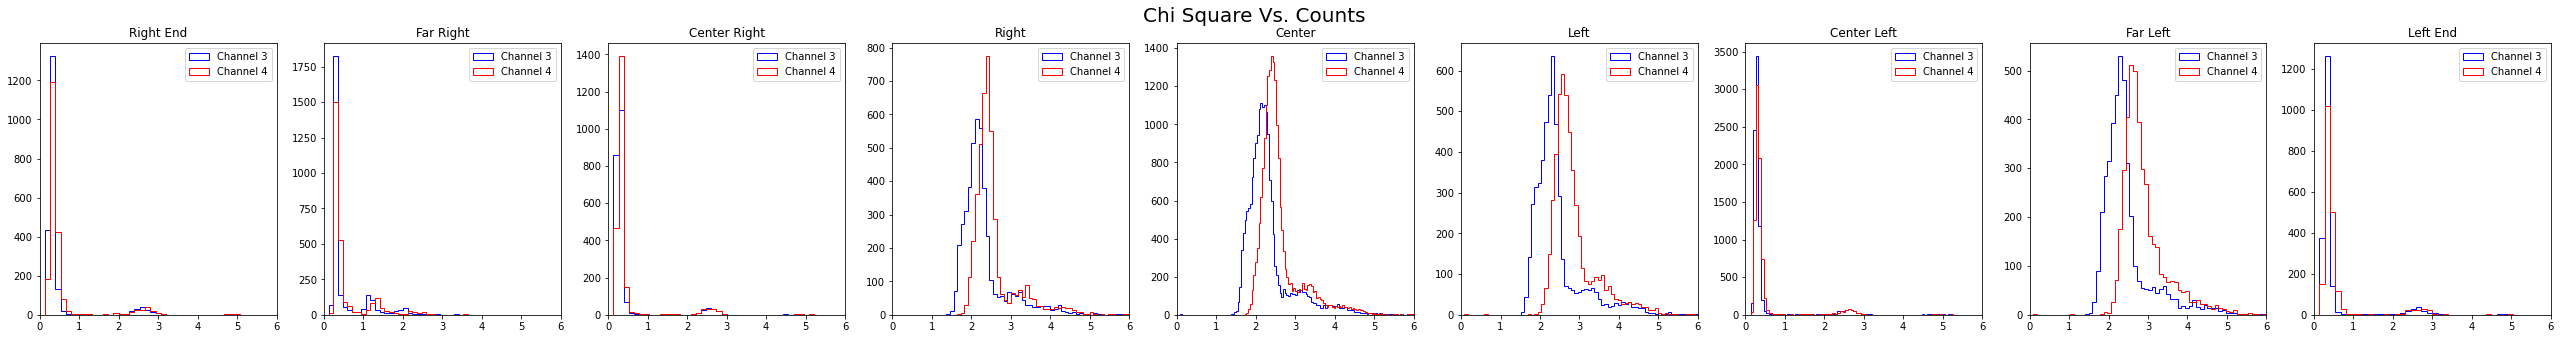

In [4]:
fig,ax = plt.subplots(1,len(dataframes),figsize=(len(dataframes)*5,5))
fig.suptitle("Chi Square Vs. Counts", fontsize=20)
for i in range(len(dataframes)):
    timecounts,timebins,bars = ax[i].hist(dataframes[i].ch3_chisq,int(np.sqrt(len(dataframes[i].ch3_chisq))),color="b", label=f"Channel 3",histtype="step",range = (0,6))
    timecounts,timebins,bars = ax[i].hist(dataframes[i].ch4_chisq,int(np.sqrt(len(dataframes[i].ch4_chisq))),color="r", label=f"Channel 4",histtype="step",range = (0,6))
    ax[i].set_xlim(0,6)
    ax[i].set_title(positions[i])
    ax[i].legend()

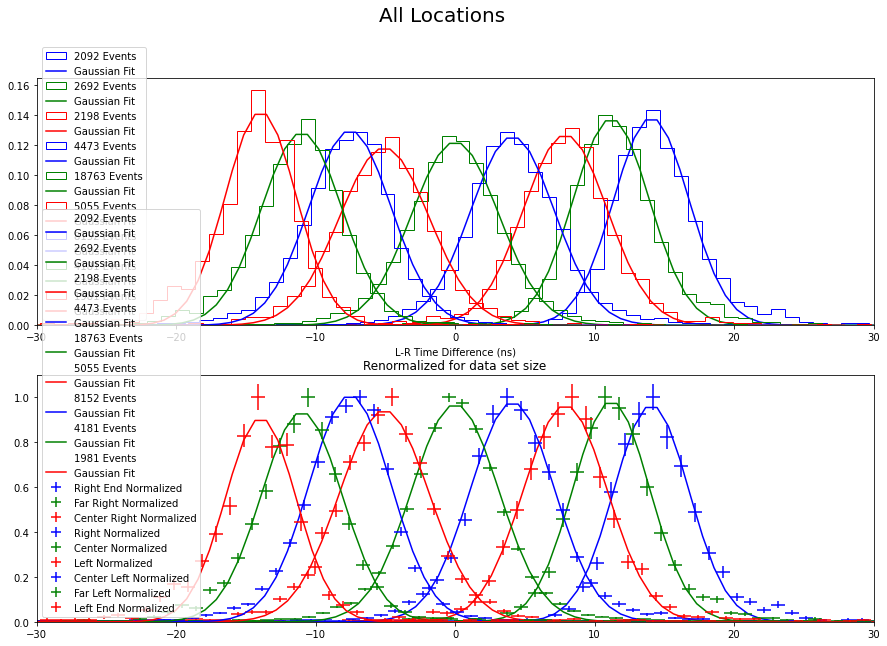

In [5]:
time_diff = []
err_time = []
fig,ax = plt.subplots(2,1,figsize=(15,10))
fig.suptitle("All Locations", fontsize=20)

for i in range(len(dataframes)):
    bincount = int(np.floor( (max(dataframes[i].eval("ch3_time_fit-ch4_time_fit"))-min(dataframes[i].eval("ch3_time_fit-ch4_time_fit")))/binresolution ))
    count,binedges,bars=ax[0].hist(dataframes[i].eval("ch3_time_fit-ch4_time_fit"),bincount, label=f"{len(dataframes[i].ch4_time_fit)} Events",color=colors[i%3],density=True,histtype="step")
    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, count)
    ax[0].plot(np.linspace(coeff[1]-20,coeff[1]+20,50),gaus(np.linspace(coeff[1]-20,coeff[1]+20,50),*coeff),label="Gaussian Fit",color=colors[i%3])
    renorm = 1/max(count)
    
    count,binedges,bars=ax[1].hist(dataframes[i].eval("ch3_time_fit-ch4_time_fit"),bincount, label=f"{len(dataframes[i].ch4_time_fit)} Events",color=colors[i%3],visible=False)
    bincenters = binedges[1:]/2+binedges[:-1]/2
    renorm = 1/max(count)
    ax[1].errorbar(bincenters,count*renorm,xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(count)*renorm,color=colors[i%3],linestyle="",label=f"{positions[i]} Normalized")
    
    coeff, covar = curve_fit(gaus, bincenters, count)
    ax[1].plot(np.linspace(coeff[1]-20,coeff[1]+20,50),gaus(np.linspace(coeff[1]-20,coeff[1]+20,50),*coeff)*renorm,label="Gaussian Fit",color=colors[i%3])
    time_diff.append(coeff[1])
    err_time.append(np.sqrt(covar[1][1]))

ax[0].set_xlabel("L-R Time Difference (ns)")
ax[0].legend()
ax[1].set_title("Renormalized for data set size")
ax[0].set_xlim(-30,30)
ax[1].set_xlim(-30,30)
ax[1].set_ylim(0,1.1)
ax[1].legend()

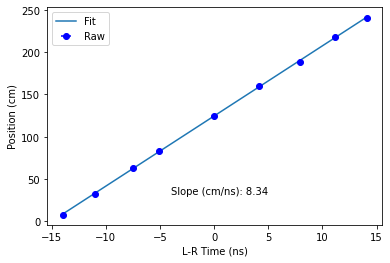

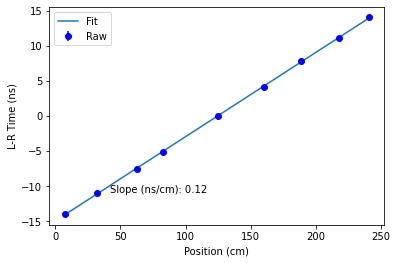

In [6]:
plt.errorbar(time_diff,locations,xerr = err_time,fmt = 'o', color = "blue", ecolor = "blue", label = "Raw")
p_time = np.polyfit(time_diff,locations,1)
plt.plot(time_diff,np.array(time_diff)*p_time[0]+p_time[1],label = "Fit")
plt.xlabel("L-R Time (ns)")
plt.ylabel("Position (cm)")
plt.annotate(str(f"Slope (cm/ns): {p_time[0]:.2f}"), xy = (time_diff[-1] + 10, locations[-2]))
plt.legend()
plt.show()

plt.errorbar(locations,time_diff,yerr = err_time,fmt = 'o', color = "blue", ecolor = "blue", label = "Raw")
pinv = np.polyfit(locations,time_diff,1)
plt.plot(locations,np.array(locations)*pinv[0]+pinv[1],label = "Fit")
plt.ylabel("L-R Time (ns)")
plt.xlabel("Position (cm)")
plt.annotate(str(f"Slope (ns/cm): {pinv[0]:.2f}"), xy = (locations[-2] + 10, time_diff[-2]))
plt.legend()
plt.show()

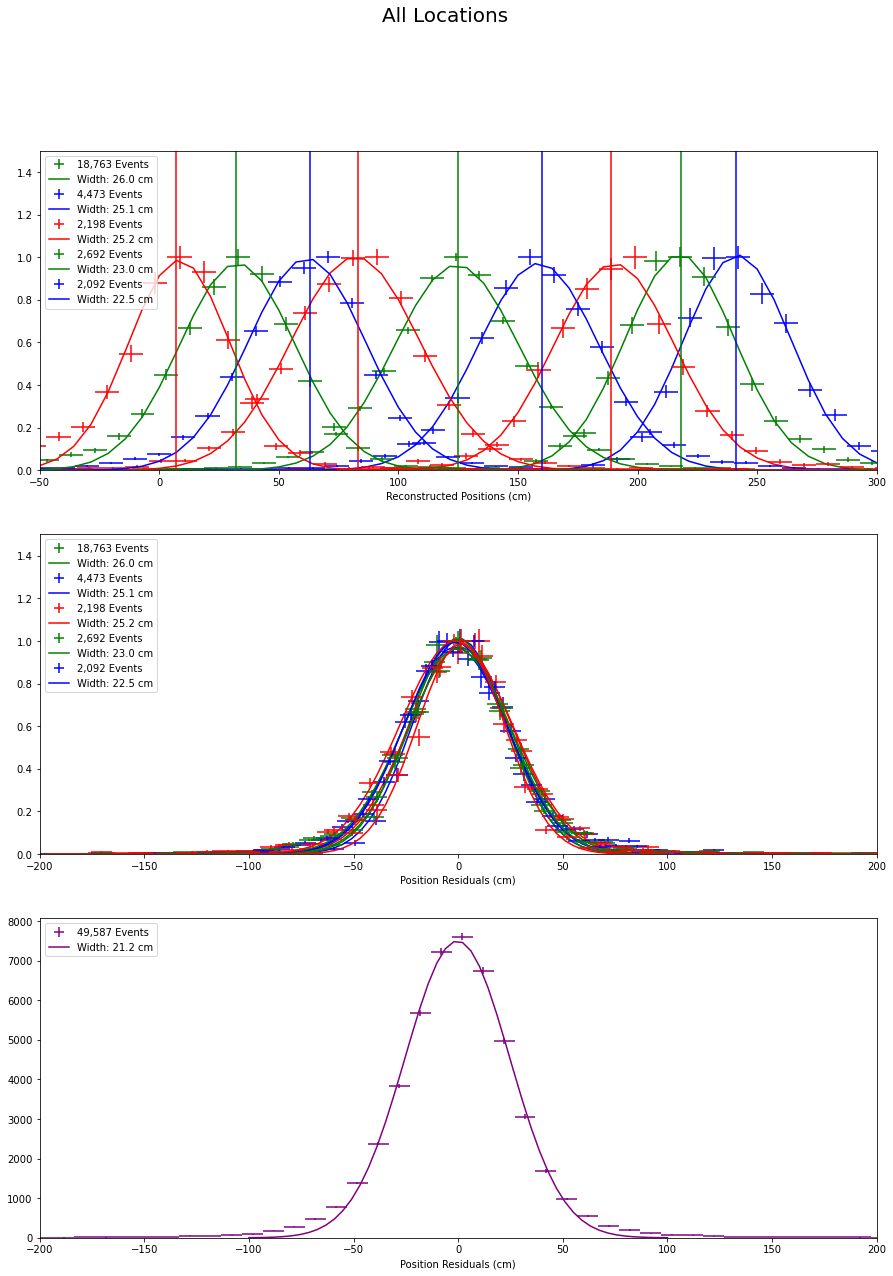

In [7]:
#avg(L-R)
histdatas= [-666]*len(dataframes)
errs = [-666]*len(dataframes)
fits = [-666]*len(dataframes)
allresiduals=[]
binresolution = 10

fig,ax = plt.subplots(3,1,figsize=(15,20))
fig.suptitle("All Locations", fontsize=20)
for i in range(len(dataframes)):
    bincount = int(np.floor( ( max(dataframes[i].eval(f"(ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]}")) 
                              -min(dataframes[i].eval(f"(ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]}")) )/binresolution ))
    histdatas[i]=ax[0].hist(dataframes[i].eval(f"(ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]}"),bincount,visible=False)
    bincenters = histdatas[i][1][1:]/2+histdatas[i][1][:-1]/2
    
    coeff, covar = curve_fit(gaus, bincenters, histdatas[i][0]/max(histdatas[i][0]),p0=(1,locations[i],25))

    fits[i], = ax[0].plot(np.linspace(-50,300,50),gaus(np.linspace(-50,300,50),*coeff),
                          label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    errs[i] = ax[0].errorbar(bincenters,histdatas[i][0]/max(histdatas[i][0]),
                   xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(histdatas[i][0])/max(histdatas[i][0]),
                   color = colors[i%3],label=f"{len(dataframes[i]):,} Events",linestyle="")
    
    #make residuals plot
    allresiduals += dataframes[i].eval(f"((ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]})-({locations[i]})").tolist()

    rescount,resbins,resbars = ax[1].hist(dataframes[i].eval(f"((ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]})-({locations[i]})"),bincount,
                                          label=f"{len(dataframes[i].ch4_time_fit)} Events",visible=False,histtype="step")
    rescenters = resbins[1:]/2+resbins[:-1]/2
    coeff, covar = curve_fit(gaus, rescenters, rescount/max(rescount),p0=(1,0,25))

    ax[1].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),
               label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    ax[1].errorbar(rescenters,rescount/max(rescount),
                   xerr = 0.5*(rescenters[1]-rescenters[0]), yerr = np.sqrt(rescount)/max(rescount), 
                   color = colors[i%3],linestyle="")

bincount = int(np.floor( ( max(allresiduals) - min(allresiduals) )/binresolution ))
#print(len(allresiduals))
rescount,resbins,resbars = ax[2].hist(allresiduals,bincount,visible=False)
#print("bin resolution",resbins[1]-resbins[0])
rescenters = resbins[1:]/2+resbins[:-1]/2
coeff_res_time, covar_res_time = curve_fit(gaus, rescenters, rescount,p0=(1000,0,25)) #,w=np.sqrt((zerr/z)**2+(err/y)**2)
myplt, = ax[2].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff_res_time),label=f"Width: {abs(coeff[2]):.1f} cm",color='purple')
myerr = ax[2].errorbar(rescenters,rescount,
               xerr = 0.5*(rescenters[1]-rescenters[0]),yerr = np.sqrt(rescount),
               color = 'purple',linestyle="", label=f"{len(allresiduals):,} Events")
for i in range(len(dataframes)):
    ax[0].vlines(locations[i],0,10,color = colors[i%3])
ax[0].set_xlim(-50,300)
ax[0].set_ylim(0,1.5)
ax[0].set_xlabel("Reconstructed Positions (cm)")
ax[0].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(0,1.5)
ax[1].set_xlabel("Position Residuals (cm)")
ax[1].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[2].set_xlim(-200,200)
ax[2].set_xlabel("Position Residuals (cm)")
ax[2].legend(handles=[myerr,myplt],loc='upper left')
plt.show()


## Amplitude Methods

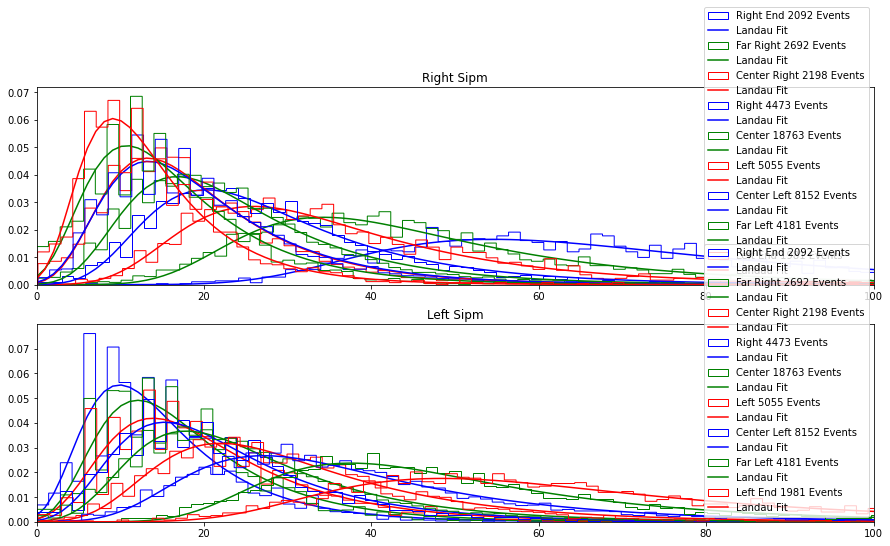

In [8]:
# Average of Amplitudes
fig,ax = plt.subplots(2,1,figsize=(15,8))
binresolution = 1.4
amplitude_R = np.array([])
err_R = np.array([])
amplitude_L = np.array([])
err_L = np.array([])

vpe_conversion = 3.4

for i in range(len(positions)):
    bincount = int(np.floor( (max(dataframes[i].ch4_P2P_fit)-min(dataframes[i].ch4_P2P_fit))/binresolution ))
    count,binedges,bars=ax[0].hist(dataframes[i].ch4_P2P_fit,bincount, label=f"{positions[i]} {len(dataframes[i].ch4_P2P_fit)} Events",color=colors[i%3],visible=True,histtype="step",density = True) #
    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(Landau, bincenters, count,p0=(0.003,0,10))
    ax[0].plot(np.linspace(0,100,100),Landau(np.linspace(0,100,100),*coeff), label=f"Landau Fit",color=colors[i%3])
    amplitude_R = np.append(amplitude_R,coeff[1])
    err_R = np.append(err_R,np.sqrt(covar[1][1]))
    ax[0].legend()
    ax[0].set_xlim(0,100)
    ax[0].set_title("Right Sipm")
    
    bincount = int(np.floor( (max(dataframes[i].ch3_P2P_fit)-min(dataframes[i].ch3_P2P_fit))/binresolution ))
    count,binedges,bars=ax[1].hist(dataframes[i].ch3_P2P_fit,bincount, label=f"{positions[i]} {len(dataframes[i].ch3_P2P_fit)} Events",color=colors[i%3],visible=True,histtype="step",density = True)
    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(Landau, bincenters, count,p0=(0.003,0,10))
    ax[1].plot(np.linspace(0,100,100),Landau(np.linspace(0,100,100),*coeff), label=f"Landau Fit",color=colors[i%3])
    amplitude_L = np.append(amplitude_L,coeff[1])
    err_L = np.append(err_L,np.sqrt(covar[1][1]))
    ax[1].legend()
    ax[1].set_xlim(0,100)
    ax[1].set_title("Left Sipm")

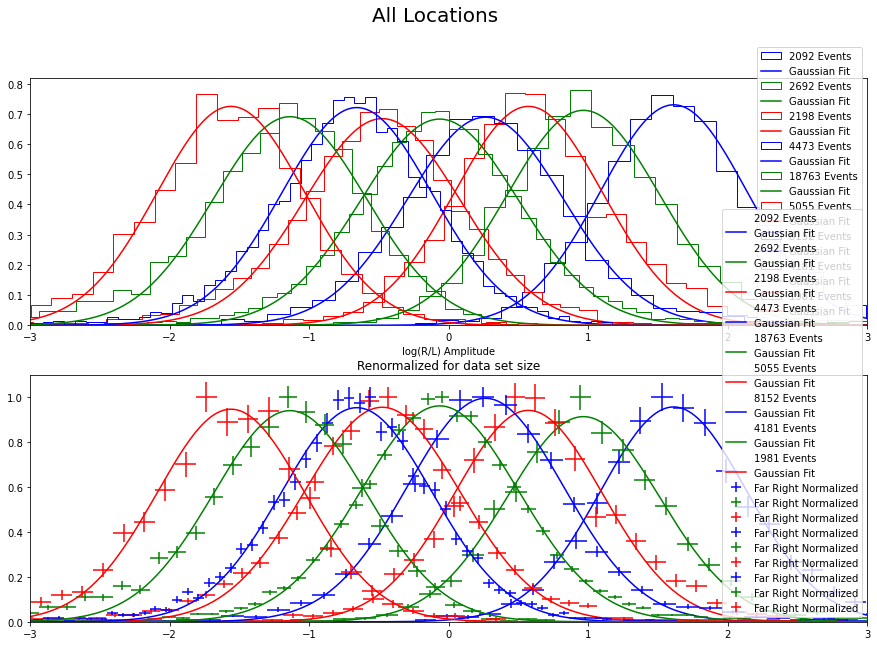

In [9]:
# Average of ln(Amplitude Ratio)
amp_ratio = []
err_amp = []
fig,ax = plt.subplots(2,1,figsize=(15,10))
fig.suptitle("All Locations", fontsize=20)

for i in range(len(dataframes)):
    bincount =  int(np.sqrt(len(dataframes[i].ch4_time_fit)))#int(np.floor( (max(dataframes[i].eval("log(ch4_P2P_fit/ch3_P2P_fit)"))-min(dataframes[i].eval("log(ch3_time_fit/ch4_time_fit)")))/binresolution ))
    count,binedges,bars=ax[0].hist(dataframes[i].eval("log(ch4_P2P_fit/ch3_P2P_fit)"),bincount, label=f"{len(dataframes[i].ch4_time_fit)} Events",color=colors[i%3],density=True,histtype="step")
    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, count,p0 = (1,0,0.1))
    ax[0].plot(np.linspace(coeff[1]-5,coeff[1]+5,500),gaus(np.linspace(coeff[1]-5,coeff[1]+5,500),*coeff),label="Gaussian Fit",color=colors[i%3])
    renorm = 1/max(count)
    
    count,binedges,bars=ax[1].hist(dataframes[i].eval("log(ch4_P2P_fit/ch3_P2P_fit)"),bincount, label=f"{len(dataframes[i].ch4_time_fit)} Events",color=colors[i%3],visible=False)
    bincenters = binedges[1:]/2+binedges[:-1]/2
    renorm = 1/max(count)
    ax[1].errorbar(bincenters,count*renorm,xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(count)*renorm,color=colors[i%3],linestyle="",label="Far Right Normalized")
    
    coeff, covar = curve_fit(gaus, bincenters, count,p0 = (1,0,0.1))
    ax[1].plot(np.linspace(coeff[1]-5,coeff[1]+5,500),gaus(np.linspace(coeff[1]-5,coeff[1]+5,500),*coeff)*renorm,label="Gaussian Fit",color=colors[i%3])
    amp_ratio.append(coeff[1])
    err_amp.append(np.sqrt(covar[1][1]))

ax[0].set_xlabel("log(R/L) Amplitude")
ax[0].legend()
ax[1].set_title("Renormalized for data set size")
ax[1].set_ylim(0,1.1)
ax[0].set_xlim(-3,3,.1)
ax[1].set_xlim(-3,3,.1)
ax[1].legend()

### Average First (ln(average of R/ average of L))

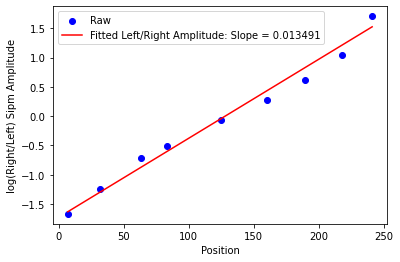

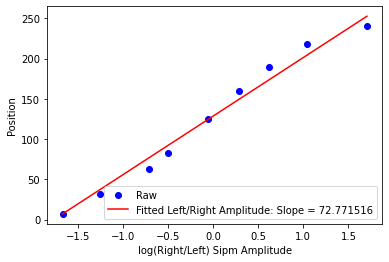

In [10]:
plt.scatter(locations,np.log(amplitude_R/amplitude_L),color = 'b', label = "Raw")
AmpLogFit = np.polyfit(locations,np.log(amplitude_R/amplitude_L),1,w=np.sqrt((err_L/amplitude_L)**2+(err_R/amplitude_R)**2))
plt.plot(np.linspace(locations[0],locations[-1],2),AmpLogFit[1]+np.linspace(locations[0],locations[-1],2)*AmpLogFit[0],label = "Fitted Left/Right Amplitude: Slope = %f" %AmpLogFit[0],color = 'r')
plt.xlabel("Position")
plt.ylabel("log(Right/Left) Sipm Amplitude")
plt.legend()
plt.show()

plt.scatter(np.log(amplitude_R/amplitude_L),locations,color = 'b', label = "Raw")
AmpLogFit = np.polyfit(np.log(amplitude_R/amplitude_L),locations,1,w=np.sqrt((err_L/amplitude_L)**2+(err_R/amplitude_R)**2))
plt.plot(np.linspace(min(np.log(amplitude_R/amplitude_L)),max(np.log(amplitude_R/amplitude_L)),2),AmpLogFit[1]+np.linspace(min(np.log(amplitude_R/amplitude_L)),max(np.log(amplitude_R/amplitude_L)),2)*AmpLogFit[0],label = "Fitted Left/Right Amplitude: Slope = %f" %AmpLogFit[0],color = 'r')
plt.ylabel("Position")
plt.xlabel("log(Right/Left) Sipm Amplitude")
plt.legend()
plt.show()

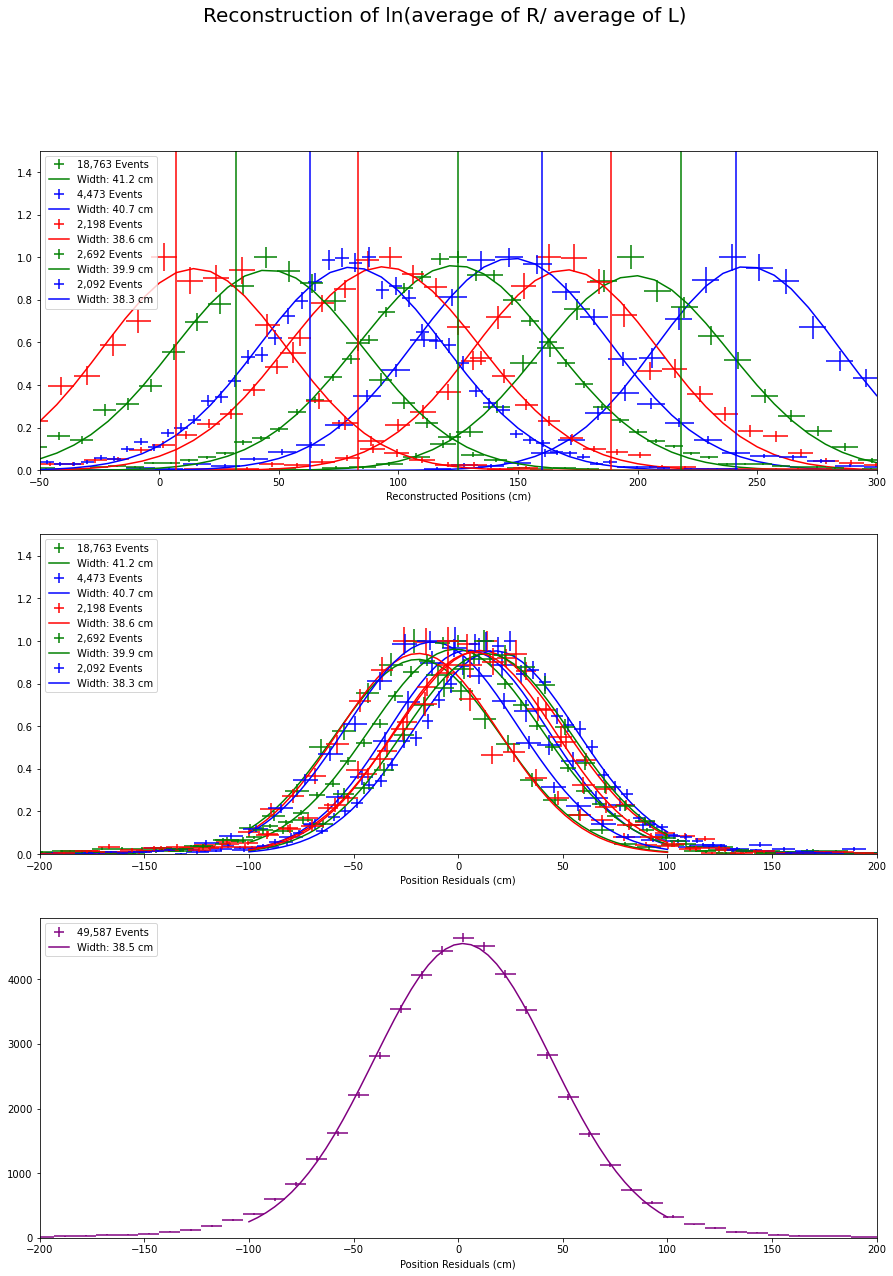

In [11]:
#ln( avg(R)/avg(L) )
histdatas= [-666]*len(dataframes)
errs = [-666]*len(dataframes)
fits = [-666]*len(dataframes)
allresiduals=[]
binresolution = 10

fig,ax = plt.subplots(3,1,figsize=(15,20))
fig.suptitle("Reconstruction of ln(average of R/ average of L)", fontsize=20)
for i in range(len(dataframes)):
    bincount = int(np.sqrt(len(dataframes[i])))#int(np.floor( ( max(dataframes[i].eval(f"(log(ch4_P2P_fit/ch3_P2P_fit)-{AmpLogFit[1]})/{AmpLogFit[0]}")) 
                              #-min(dataframes[i].eval(f"(log(ch4_P2P_fit/ch3_P2P_fit)-{AmpLogFit[1]})/{AmpLogFit[0]}")) )/binresolution ))
    histdatas[i]=ax[0].hist(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpLogFit[0]}+{AmpLogFit[1]}"),bincount,visible=False)
    bincenters = histdatas[i][1][1:]/2+histdatas[i][1][:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, histdatas[i][0]/max(histdatas[i][0]),p0=(1,locations[i],25))
    
    fits[i], = ax[0].plot(np.linspace(-50,300,50),gaus(np.linspace(-50,300,50),*coeff),
                          label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    errs[i] = ax[0].errorbar(bincenters,histdatas[i][0]/max(histdatas[i][0]),
                   xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(histdatas[i][0])/max(histdatas[i][0]),
                   color = colors[i%3],label=f"{len(dataframes[i]):,} Events",linestyle="")
    
    #make residuals plot
    allresiduals += dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpLogFit[0]}+{AmpLogFit[1]}-({locations[i]})").tolist()

    rescount,resbins,resbars = ax[1].hist(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpLogFit[0]}+{AmpLogFit[1]}-({locations[i]})"),bincount,
                                          label=f"{len(dataframes[i].ch4_time_fit)} Events",visible=False,histtype="step")
    rescenters = resbins[1:]/2+resbins[:-1]/2
    coeff, covar = curve_fit(gaus, rescenters, rescount/max(rescount),p0=(1,0,25))
    
    ax[1].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),
               label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    ax[1].errorbar(rescenters,rescount/max(rescount),
                   xerr = 0.5*(rescenters[1]-rescenters[0]), yerr = np.sqrt(rescount)/max(rescount), 
                   color = colors[i%3],linestyle="")
for i in range(len(dataframes)):
    ax[0].vlines(locations[i],0,10,color = colors[i%3])
bincount = int(np.floor( ( max(allresiduals) - min(allresiduals) )/binresolution ))
#print(len(allresiduals))
rescount,resbins,resbars = ax[2].hist(allresiduals,bincount,visible=False)
#print("bin resolution",resbins[1]-resbins[0])
rescenters = resbins[1:]/2+resbins[:-1]/2
coeff_res_amp, covar_res_amp = curve_fit(gaus, rescenters, rescount,p0=(1000,0,25))
myplt, = ax[2].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff_res_amp),label=f"Width: {abs(coeff[2]):.1f} cm",color='purple')
myerr = ax[2].errorbar(rescenters,rescount,
               xerr = 0.5*(rescenters[1]-rescenters[0]),yerr = np.sqrt(rescount),
               color = 'purple',linestyle="", label=f"{len(allresiduals):,} Events")

ax[0].set_xlim(-50,300)
ax[0].set_ylim(0,1.5)
ax[0].set_xlabel("Reconstructed Positions (cm)")
ax[0].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(0,1.5)
ax[1].set_xlabel("Position Residuals (cm)")
ax[1].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[2].set_xlim(-200,200)
ax[2].set_xlabel("Position Residuals (cm)")
ax[2].legend(handles=[myerr,myplt],loc='upper left')
plt.show()


### Average Last (average of ln(Amplitude Ratio))

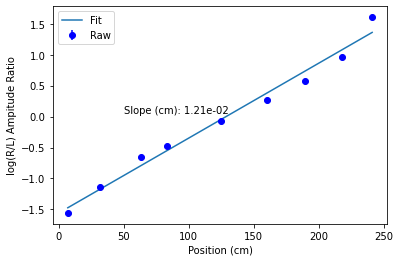

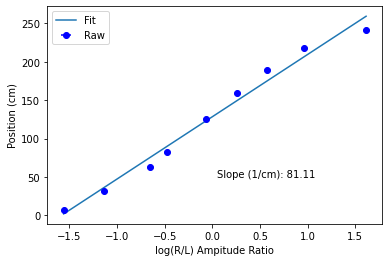

In [12]:
plt.errorbar(locations,amp_ratio,yerr = err_amp,fmt = 'o', color = "blue", ecolor = "blue", label = "Raw")
AmpAvgLog = np.polyfit(locations,amp_ratio,1)
plt.plot(locations,np.array(locations)*AmpAvgLog[0]+AmpAvgLog[1],label = "Fit")
plt.ylabel("log(R/L) Ampitude Ratio")
plt.xlabel("Position (cm)")
#plt.annotate(str(f"Slope (1/cm): {AmpAvgLog[0]:.2f}"), xy = (amp_ratio[-2] + 10, locations[-2]))
plt.text(50, 0.05,f"Slope (cm): {AmpAvgLog[0]:.2e} ")
plt.legend()
plt.show()

plt.errorbar(amp_ratio,locations,xerr = err_amp,fmt = 'o', color = "blue", ecolor = "blue", label = "Raw")
AmpAvgLog = np.polyfit(amp_ratio,locations,1)
plt.plot(amp_ratio,np.array(amp_ratio)*AmpAvgLog[0]+AmpAvgLog[1],label = "Fit")
plt.xlabel("log(R/L) Ampitude Ratio")
plt.ylabel("Position (cm)")
#plt.annotate(str(f"Slope (1/cm): {AmpAvgLog[0]:.2f}"), xy = (amp_ratio[-2] + 10, locations[-2]))
plt.text(0.05, 50,f"Slope (1/cm): {AmpAvgLog[0]:.2f} ")
plt.legend()
plt.show()


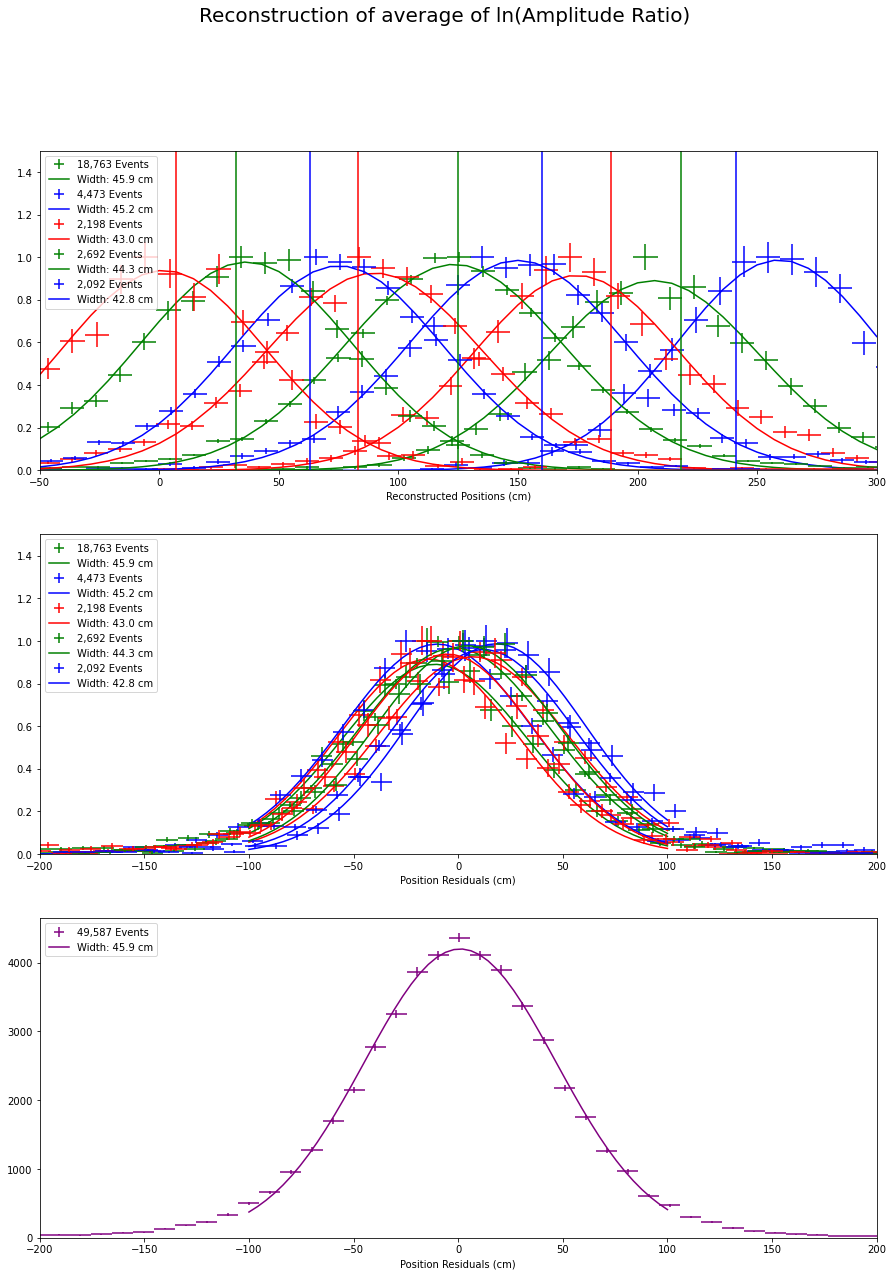

In [13]:
histdatas= [-666]*len(dataframes)
errs = [-666]*len(dataframes)
fits = [-666]*len(dataframes)
allresiduals=[]
binresolution = 10

fig,ax = plt.subplots(3,1,figsize=(15,20))
fig.suptitle("Reconstruction of average of ln(Amplitude Ratio)", fontsize=20)
for i in range(len(dataframes)):
    bincount = int(np.floor( ( max(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpAvgLog[0]}+{AmpAvgLog[1]}")) 
                              -min(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpAvgLog[0]}+{AmpAvgLog[1]}")) )/binresolution ))
    histdatas[i]=ax[0].hist(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpAvgLog[0]}+{AmpAvgLog[1]}"),bincount,visible=False)
    bincenters = histdatas[i][1][1:]/2+histdatas[i][1][:-1]/2
    
    coeff, covar = curve_fit(gaus, bincenters, histdatas[i][0]/max(histdatas[i][0]),p0=(1,locations[i],25))
    
    fits[i], = ax[0].plot(np.linspace(-50,300,50),gaus(np.linspace(-50,300,50),*coeff),
                          label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    errs[i] = ax[0].errorbar(bincenters,histdatas[i][0]/max(histdatas[i][0]),
                   xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(histdatas[i][0])/max(histdatas[i][0]),
                   color = colors[i%3],label=f"{len(dataframes[i]):,} Events",linestyle="")
    
    #make residuals plot
    allresiduals += dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpAvgLog[0]}+{AmpAvgLog[1]}-({locations[i]})").tolist()

    rescount,resbins,resbars = ax[1].hist(dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpAvgLog[0]}+{AmpAvgLog[1]}-({locations[i]})"),bincount,
                                          label=f"{len(dataframes[i].ch4_time_fit)} Events",visible=False,histtype="step")
    rescenters = resbins[1:]/2+resbins[:-1]/2
    coeff, covar = curve_fit(gaus, rescenters, rescount/max(rescount),p0=(1,0,25))
    
    ax[1].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),
               label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    ax[1].errorbar(rescenters,rescount/max(rescount),
                   xerr = 0.5*(rescenters[1]-rescenters[0]), yerr = np.sqrt(rescount)/max(rescount), 
                   color = colors[i%3],linestyle="")
for i in range(len(dataframes)):
    ax[0].vlines(locations[i],0,10,color = colors[i%3])
bincount = int(np.floor( ( max(allresiduals) - min(allresiduals) )/binresolution ))
#print(len(allresiduals))
rescount,resbins,resbars = ax[2].hist(allresiduals,bincount,visible=False)
#print("bin resolution",resbins[1]-resbins[0])
rescenters = resbins[1:]/2+resbins[:-1]/2
coeff, covar = curve_fit(gaus, rescenters, rescount,p0=(1000,0,25))
myplt, = ax[2].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),label=f"Width: {abs(coeff[2]):.1f} cm",color='purple')
myerr = ax[2].errorbar(rescenters,rescount,
               xerr = 0.5*(rescenters[1]-rescenters[0]),yerr = np.sqrt(rescount),
               color = 'purple',linestyle="", label=f"{len(allresiduals):,} Events")

ax[0].set_xlim(-50,300)
ax[0].set_ylim(0,1.5)
ax[0].set_xlabel("Reconstructed Positions (cm)")
ax[0].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(0,1.5)
ax[1].set_xlabel("Position Residuals (cm)")
ax[1].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[2].set_xlim(-200,200)
ax[2].set_xlabel("Position Residuals (cm)")
ax[2].legend(handles=[myerr,myplt],loc='upper left')
plt.show()

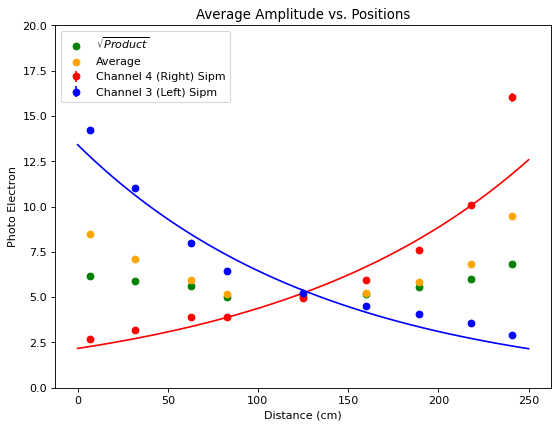

In [14]:
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(locations,amplitude_R/vpe_conversion,yerr=err_R,fmt = 'o',color = 'r', label = 'Channel 4 (Right) Sipm')
plt.errorbar(locations,amplitude_L/vpe_conversion,yerr=err_L,fmt = 'o', color = 'b', label = 'Channel 3 (Left) Sipm')

popt1, pcov1 = curve_fit(lambda t,a,b: a*np.exp(b*t),  locations,  amplitude_R/vpe_conversion,p0 = (4,0.01),sigma = err_R)
plt.plot(np.linspace(0,250,100),popt1[0]*np.exp(popt1[1]*np.linspace(0,250,100)),color = 'r')
popt2, pcov2 = curve_fit(lambda t,a,b: a*np.exp(b*t),  locations,  amplitude_L/vpe_conversion,p0 = (4,-0.01),sigma= err_L)
plt.plot(np.linspace(0,250,100),popt2[0]*np.exp(popt2[1]*np.linspace(0,250,100)),color = 'b')
plt.scatter(locations,np.sqrt(np.array(amplitude_R/vpe_conversion)*np.array(amplitude_L/vpe_conversion)),color = 'g', label = '$\sqrt{Product}$')
plt.scatter(locations,(np.array(amplitude_R/vpe_conversion)+np.array(amplitude_L/vpe_conversion))/2,color = 'orange', label = 'Average')
plt.title("Average Amplitude vs. Positions")
plt.xlabel("Distance (cm)")
plt.ylabel("Photo Electron")
plt.ylim(0,20)
plt.legend()


## Weighted Average of Time and Amplitude

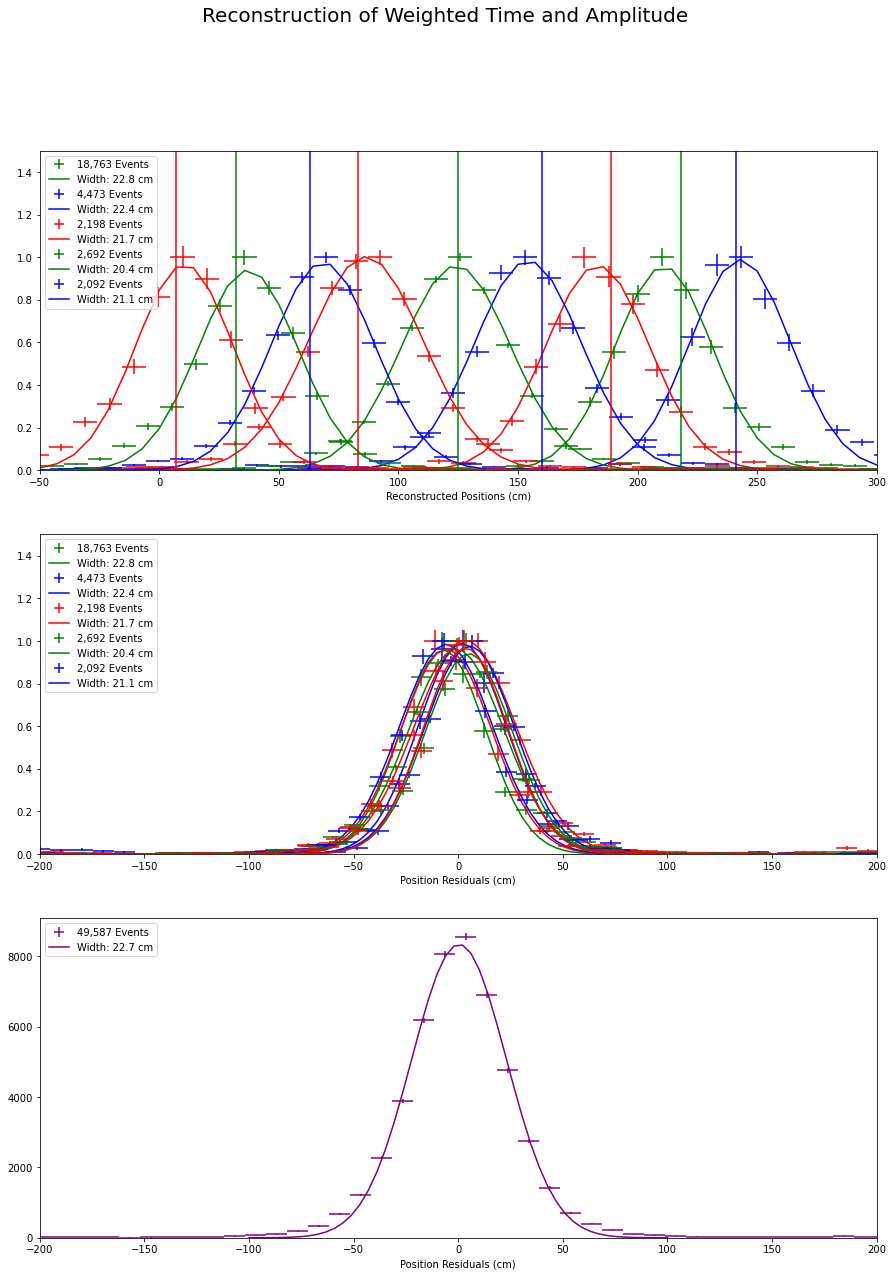

[0.3848722560368351, 0.18241514947664206, 0.3032242510232321, 0.2482024011590332, 0.19199129994154251, 0.21938183754834148, 0.15098407579874126, 0.27822432933670926, 0.4496963948464812]
0.2676657772408398


In [15]:
histdatas= [-666]*len(dataframes)
errs = [-666]*len(dataframes)
fits = [-666]*len(dataframes)
allresiduals=[]
binresolution = 10
cov = []
fig,ax = plt.subplots(3,1,figsize=(15,20))
fig.suptitle("Reconstruction of Weighted Time and Amplitude", fontsize=20)
for i in range(len(dataframes)):
    x_time = dataframes[i].eval(f"((ch3_time_fit-ch4_time_fit)*{p_time[0]}+{p_time[1]})")
    x_amp = dataframes[i].eval(f"log(ch4_P2P_fit/ch3_P2P_fit)*{AmpLogFit[0]}+{AmpLogFit[1]}")
    x_tot = (x_time/coeff_res_time[2] + x_amp/coeff_res_amp[2]) / (1/coeff_res_time[2] + 1/coeff_res_amp[2])
    bincount = int(np.floor( ( max(x_tot) 
                              -min(x_tot) )/binresolution ))
    histdatas[i]=ax[0].hist(x_tot,bincount,visible=False)
    bincenters = histdatas[i][1][1:]/2+histdatas[i][1][:-1]/2
    
    coeff, covar = curve_fit(gaus, bincenters, histdatas[i][0]/max(histdatas[i][0]),p0=(1,locations[i],25))
    
    fits[i], = ax[0].plot(np.linspace(-50,300,50),gaus(np.linspace(-50,300,50),*coeff),
                          label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    errs[i] = ax[0].errorbar(bincenters,histdatas[i][0]/max(histdatas[i][0]),
                   xerr=0.5*(bincenters[1]-bincenters[0]),yerr = np.sqrt(histdatas[i][0])/max(histdatas[i][0]),
                   color = colors[i%3],label=f"{len(dataframes[i]):,} Events",linestyle="")
    cov.append(np.sqrt(covar[1][1]))
    #make residuals plot
    allresiduals += x_tot.sub(locations[i]).tolist()

    rescount,resbins,resbars = ax[1].hist(x_tot.sub(locations[i]),bincount,
                                          label=f"{len(dataframes[i].ch4_time_fit)} Events",visible=False,histtype="step")
    rescenters = resbins[1:]/2+resbins[:-1]/2
    coeff, covar = curve_fit(gaus, rescenters, rescount/max(rescount),p0=(1,0,25))
    
    ax[1].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),
               label=f"Width: {abs(coeff[2]):.1f} cm",color=colors[i%3])
    ax[1].errorbar(rescenters,rescount/max(rescount),
                   xerr = 0.5*(rescenters[1]-rescenters[0]), yerr = np.sqrt(rescount)/max(rescount), 
                   color = colors[i%3],linestyle="")
for i in range(len(dataframes)):
    ax[0].vlines(locations[i],0,10,color = colors[i%3])
bincount = int(np.floor( ( max(allresiduals) - min(allresiduals) )/binresolution ))
#print(len(allresiduals))
rescount,resbins,resbars = ax[2].hist(allresiduals,bincount,visible=False)
#print("bin resolution",resbins[1]-resbins[0])
rescenters = resbins[1:]/2+resbins[:-1]/2
coeff, covar = curve_fit(gaus, rescenters, rescount,p0=(1000,0,25))
myplt, = ax[2].plot(np.linspace(-100,100,50),gaus(np.linspace(-100,100,50),*coeff),label=f"Width: {abs(coeff[2]):.1f} cm",color='purple')
myerr = ax[2].errorbar(rescenters,rescount,
               xerr = 0.5*(rescenters[1]-rescenters[0]),yerr = np.sqrt(rescount),
               color = 'purple',linestyle="", label=f"{len(allresiduals):,} Events")

ax[0].set_xlim(-50,300)
ax[0].set_ylim(0,1.5)
ax[0].set_xlabel("Reconstructed Positions (cm)")
ax[0].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(0,1.5)
ax[1].set_xlabel("Position Residuals (cm)")
ax[1].legend(handles=[errs[4],fits[4],errs[3],fits[3],errs[2],fits[2],errs[1],fits[1],errs[0],fits[0]],loc='upper left')
ax[2].set_xlim(-200,200)
ax[2].set_xlabel("Position Residuals (cm)")
ax[2].legend(handles=[myerr,myplt],loc='upper left')
plt.show()
print(cov)
print(np.mean(cov))